In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pyodbc
import math

In [2]:
def round_up(n, decimals=0):
    multiplier = 10 ** decimals
    return math.ceil(n * multiplier) / multiplier

In [44]:
sql_conn = pyodbc.connect('DRIVER={SQL Server};'
                            'SERVER=L_AAGDATIX;'
                            'DATABASE=DatixCRM;'
                            'Trusted_Connection=yes') 
query = "set transaction isolation level read uncommitted select a.inc_dincident,a.inc_time,a.inc_dreported,a.inc_submittedtime,a.inc_reportedby,b.description from DatixCRM.dbo.code_unit b join DatixCRM.dbo.incidents_main a on a.inc_unit = b.code where a.inc_type='PAT' and a.inc_category='MEDIC' and a.inc_organisation='QA'"
df = pd.read_sql(query, sql_conn)
df = df.rename(columns={'description':'division-care_group'})
print(df)

     inc_dincident inc_time inc_dreported inc_submittedtime  \
0       2016-03-31     0800    2016-03-31              2025   
1       2016-03-31     2100    2016-04-01              1553   
2       2016-04-01     1957    2016-04-01              2002   
3       2016-03-25     1400    2016-04-01              2126   
4       2016-04-02     0730    2016-04-02              0752   
5       2016-04-01     1200    2016-04-02              1042   
6       2016-04-01     1800    2016-04-02              1051   
7       2016-04-02     1600    2016-04-02              1713   
8       2016-04-02     1700    2016-04-02              1806   
9       2016-04-03     1630    2016-04-03              1710   
10      2016-04-03     1715    2016-04-03              1917   
11      2016-04-02     1000    2016-04-04              1150   
12      2016-04-02     1000    2016-04-04              1209   
13      2016-04-02     1000    2016-04-04              1350   
14      2016-04-02     1100    2016-04-04              

In [45]:
divider = df['division-care_group'].str.split(" Division - ",n=1,expand=True)
df['division'] = divider[0]
df['care_group'] = divider[1]
df['division'] = df['division'].str.replace(' and ',' & ')

In [46]:
df_inc = df.copy()
df_inc = df_inc[df_inc.inc_dincident > '2016-03-31']
df_inc = df_inc[df_inc.inc_dincident < '2019-11-18']
print(df_inc)

     inc_dincident inc_time inc_dreported inc_submittedtime  \
2       2016-04-01     1957    2016-04-01              2002   
4       2016-04-02     0730    2016-04-02              0752   
5       2016-04-01     1200    2016-04-02              1042   
6       2016-04-01     1800    2016-04-02              1051   
7       2016-04-02     1600    2016-04-02              1713   
8       2016-04-02     1700    2016-04-02              1806   
9       2016-04-03     1630    2016-04-03              1710   
10      2016-04-03     1715    2016-04-03              1917   
11      2016-04-02     1000    2016-04-04              1150   
12      2016-04-02     1000    2016-04-04              1209   
13      2016-04-02     1000    2016-04-04              1350   
14      2016-04-02     1100    2016-04-04              1420   
15      2016-04-02     1200    2016-04-04              1431   
16      2016-04-04     1450    2016-04-04              1503   
17      2016-04-02     1200    2016-04-04              

In [47]:
df_inc['hour'] = df_inc['inc_time'].str[:2]
df_inc = df_inc.astype({'hour':'int'})
print(df_inc[df_inc.hour == 23])

     inc_dincident inc_time inc_dreported inc_submittedtime  \
80      2016-04-14     2300    2016-04-15              2326   
101     2016-04-20     2359    2016-04-21              1713   
146     2016-05-01     2300    2016-05-02              0830   
166     2016-05-05     2315    2016-05-06              0706   
184     2016-05-08     2300    2016-05-09              0058   
527     2016-07-14     2330    2016-07-15              1301   
580     2016-07-28     2347    2016-07-29              0003   
581     2016-07-28     2300    2016-07-29              0557   
612     2016-08-03     2300    2016-08-04              0050   
613     2016-08-03     2300    2016-08-04              0518   
621     2016-08-02     2339    2016-08-05              0854   
629     2016-08-08     2300    2016-08-09              0458   
689     2016-08-21     2300    2016-08-22              0032   
798     2016-09-11     2330    2016-09-12              0044   
827     2016-09-15     2300    2016-09-16              

In [48]:
total_days = (max(df_inc.inc_dincident)-min(df_inc.inc_dincident)).days

(-0.5, 3301.5, 495.5, -0.5)

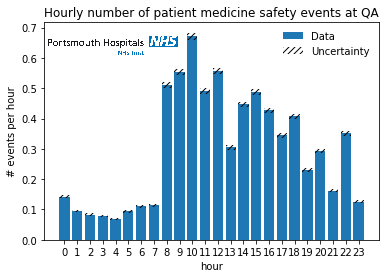

In [49]:
bins = [i-0.5 for i in range(25)]
data_x = [i for i in range(24)]
data_y_tot,_ = np.histogram(df_inc.hour.values, bins=bins)
data_y = data_y_tot/total_days
data_y_err = np.sqrt(data_y_tot)/total_days
plt.bar(data_x,data_y,label='Data')
plt.bar(data_x,data_y_err,bottom=data_y-data_y_err/2,alpha=0.5,color='none',hatch="////",label='Uncertainty')
plt.legend(frameon=False)
ax = plt.gca()
ax.set_xticks(np.arange(24))
plt.xlabel('hour');
plt.ylabel('# events per hour')
plt.title('Hourly number of patient medicine safety events at QA')
img = plt.imread("nhsportsmouth.png");
ax = plt.axes([0.125+0.01,0.65, 0.3, 0.3], frameon=True)  # Change the numbers in this array to position your image [left, bottom, width, height])
ax.imshow(img)
ax.axis('off')  # get rid of the ticks and ticklabels

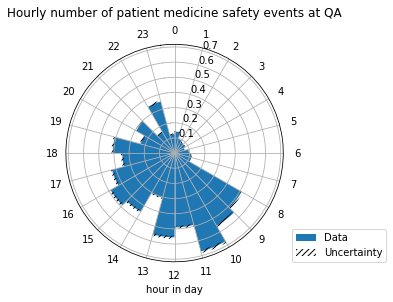

In [50]:
# Compute pie slices
N = 24
width = 2 * np.pi/N
theta = np.linspace(0.0 + width, 2 * np.pi + width, N, endpoint=False)
theta_deg = np.linspace(0.0 + 7.5, 360 + 7.5, N, endpoint=False)
radii = data_y
radii_err = data_y_err

ax = plt.subplot(111, projection='polar')
ax.bar(theta, radii, width=width,label='Data');
ax.bar(theta, radii_err, bottom=radii-radii_err/2,width=width,alpha=0.5,color='none',hatch="////",label='Uncertainty');
ax.set_theta_offset(np.pi/2 + width/2)
ax.set_theta_direction(-1)
plt.xlabel('hour in day')
plt.title('Hourly number of patient medicine safety events at QA',y=1.1)
plt.legend(loc=(1.04,0))
lines, labels = plt.thetagrids( theta_deg, (data_x) )

In [51]:
morning_radii = np.zeros(len(radii))
afternoon_radii = np.zeros(len(radii))
evening_radii = np.zeros(len(radii))
for i in range(24):
    print(i)
    if i <= 7: morning_radii[i] = radii[i]
    elif i >= 8 and i <= 15: afternoon_radii[i] = radii[i]
    else: evening_radii[i] = radii[i]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


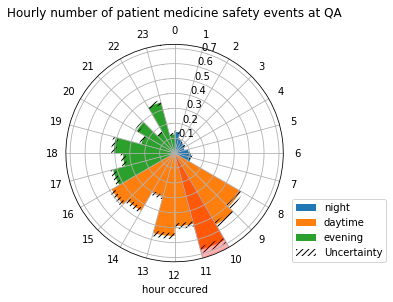

In [52]:
ax = plt.subplot(111, projection='polar');
ax.bar(theta, morning_radii, width=width,label='night');
ax.bar(theta, afternoon_radii, width=width,label='daytime');
ax.bar(theta, evening_radii, width=width,label='evening');
ax.bar(theta, 2*radii_err, bottom=radii-radii_err,width=width,alpha=0.5,color='none',hatch="////",label='Uncertainty');
ax.set_theta_offset(np.pi/2 + width/2)
ax.set_theta_direction(-1)
#ax.set_yticklabels([])
plt.xlabel('hour occured')
plt.title('Hourly number of patient medicine safety events at QA',y=1.1)
plt.legend(loc=(1.04,0))
lines, labels = plt.thetagrids( theta_deg, (data_x) );
ax.axvspan(theta[np.argmax(radii)]-width/2,theta[np.argmax(radii)]+width/2,color='red',alpha=0.3);

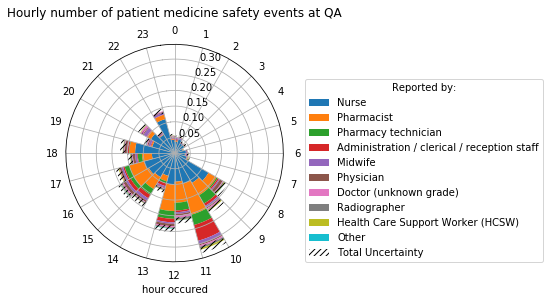

In [53]:
reportedby_counts = df_inc['inc_reportedby'].value_counts().drop(labels=[''])
reportedby_counts_nlargest = reportedby_counts.nlargest(9)
thresh = reportedby_counts_nlargest[-1]
reportedby_counts = reportedby_counts.append(pd.Series(reportedby_counts[reportedby_counts.values < thresh].sum(),index=['Other']))
reportedby_counts = reportedby_counts[reportedby_counts.values >= thresh]

ax = plt.subplot(111, projection='polar')
cumulative_bottom = 0
for i,counts in reportedby_counts.items():
    radii_reported_tot,_ = np.histogram(df_inc[df_inc['inc_reportedby']==i].hour.values, bins=bins)
    radii_reported = radii_reported_tot/total_days
    ax.bar(theta, radii_reported, bottom=cumulative_bottom, width=width, label=i);
    cumulative_bottom += radii_reported

ax.bar(theta, radii_err, bottom=cumulative_bottom-radii_err/2,width=width,alpha=0.5,color='none',hatch="////",label='Total Uncertainty');
ax.set_theta_offset(np.pi/2 + width/2)
ax.set_theta_direction(-1)
#ax.set_yticklabels([])
plt.xlabel('hour occured')
plt.title('Hourly number of patient medicine safety events at QA',y=1.1)
plt.legend(loc=(1.1,0),title='Reported by:')
lines, labels = plt.thetagrids( theta_deg, (data_x) )

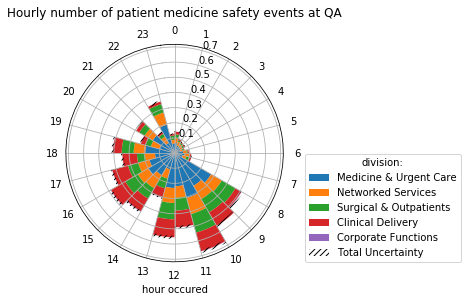

In [55]:
division_counts = df_inc['division'].value_counts()

ax = plt.subplot(111, projection='polar')
cumulative_bottom = 0
for i,counts in division_counts.items():
    radii_division_tot,_ = np.histogram(df_inc[df_inc['division']==i].hour.values, bins=bins)
    radii_division = radii_division_tot/total_days
    ax.bar(theta, radii_division, bottom=cumulative_bottom, width=width, label=i);
    cumulative_bottom += radii_division

ax.bar(theta, radii_err, bottom=cumulative_bottom-radii_err/2,width=width,alpha=0.5,color='none',hatch="////",label='Total Uncertainty');
ax.set_theta_offset(np.pi/2 + width/2)
ax.set_theta_direction(-1)
#ax.set_yticklabels([])
plt.xlabel('hour occured')
plt.title('Hourly number of patient medicine safety events at QA',y=1.1)
plt.legend(loc=(1.1,0),title='division:')
lines, labels = plt.thetagrids( theta_deg, (data_x) )

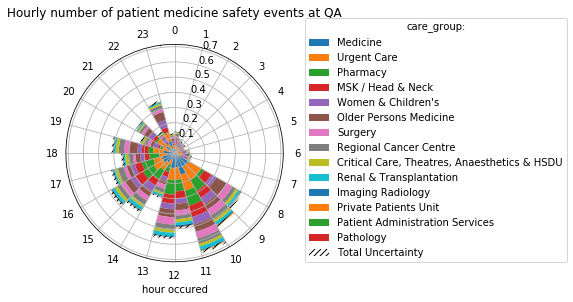

In [56]:
care_group_counts = df_inc['care_group'].value_counts()

ax = plt.subplot(111, projection='polar')
cumulative_bottom = 0
for i,counts in care_group_counts.items():
    radii_care_group_tot,_ = np.histogram(df_inc[df_inc['care_group']==i].hour.values, bins=bins)
    radii_care_group = radii_care_group_tot/total_days
    ax.bar(theta, radii_care_group, bottom=cumulative_bottom, width=width, label=i);
    cumulative_bottom += radii_care_group

ax.bar(theta, radii_err, bottom=cumulative_bottom-radii_err/2,width=width,alpha=0.5,color='none',hatch="////",label='Total Uncertainty');
ax.set_theta_offset(np.pi/2 + width/2)
ax.set_theta_direction(-1)
#ax.set_yticklabels([])
plt.xlabel('hour occured')
plt.title('Hourly number of patient medicine safety events at QA',y=1.1)
plt.legend(loc=(1.1,0),title='care_group:')
lines, labels = plt.thetagrids( theta_deg, (data_x) )

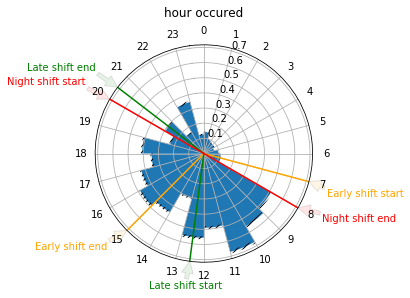

In [12]:
ax = plt.subplot(111, projection='polar')
ax.bar(theta, radii, width=width,label='Data');
ax.bar(theta, radii_err, bottom=radii-radii_err/2,width=width,alpha=0.5,color='none',hatch="////",label='Uncertainty');
ax.set_theta_offset(np.pi/2 + width/2)
ax.set_theta_direction(-1)
#ax.set_yticklabels([])
plt.title('hour occured',y=1.1)
lines, labels = plt.thetagrids( theta_deg, (data_x) )
ax.axvline(theta[7]-width/2,color='orange');
ax.axvline(theta[15]-width/2,color='orange');
ax.axvline(theta[12],color='green');
ax.axvline(theta[20],color='green');
ax.axvline(theta[20]-width/2,color='red');
ax.axvline(theta[8]-width/2,color='red');
ax.annotate('Early shift start',xy=(theta[7]-width/2,ax.get_ylim()[1]),xytext=(theta[7]-width/2,1.1),color='orange',ha='center',
           arrowprops=dict(facecolor='orange',alpha=0.1));
ax.annotate('Early shift end',xy=(theta[15]-width/2,ax.get_ylim()[1]),xytext=(theta[15]-width/2,0.9),color='orange',ha='right',
           arrowprops=dict(facecolor='orange',alpha=0.1));
ax.annotate('Late shift start',xy=(theta[12],ax.get_ylim()[1]),xytext=(theta[12],0.9),color='green',ha='center',
           arrowprops=dict(facecolor='green',alpha=0.1));
ax.annotate('Late shift end',xy=(theta[20],ax.get_ylim()[1]),xytext=(theta[20],0.9),color='green',ha='right',
           arrowprops=dict(facecolor='green',alpha=0.1));
ax.annotate('Night shift start',xy=(theta[20]-width/2,ax.get_ylim()[1]),xytext=(theta[20]-width/2,0.9),color='red',ha='right',
           arrowprops=dict(facecolor='red',alpha=0.1));
ax.annotate('Night shift end',xy=(theta[8]-width/2,ax.get_ylim()[1]),xytext=(theta[8]-width/2,0.9),color='red',ha='left',
           arrowprops=dict(facecolor='red',alpha=0.1));

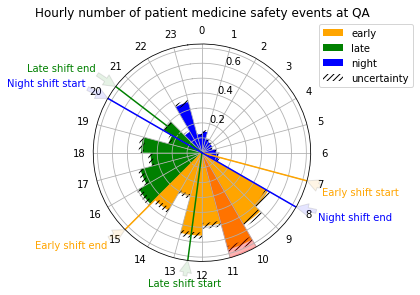

In [13]:
early_radii = np.zeros(len(radii))
late_radii = np.zeros(len(radii))
night_radii = np.zeros(len(radii))
for i in range(24):
    if i >= 8 and i <= 14: early_radii[i] = radii[i]
    elif i >= 15 and i <= 20: late_radii[i] = radii[i]
    else: night_radii[i] = radii[i]
ax = plt.subplot(111, projection='polar');
ax.bar(theta, early_radii, width=width,label='early',color='orange');
ax.bar(theta, late_radii, width=width,label='late',color='green');
ax.bar(theta, night_radii, width=width,label='night',color='blue');
ax.bar(theta, 2*radii_err, bottom=radii-radii_err,width=width,alpha=0.5,color='none',hatch="////",label='uncertainty');
ax.set_theta_offset(np.pi/2 + width/2)
ax.set_theta_direction(-1)
ax.set_yticklabels(['',0.2,'',0.4,'',0.6])
#plt.xlabel('hour occured')
plt.title('Hourly number of patient medicine safety events at QA',y=1.1)
plt.legend(loc=(1.04,0.8))
lines, labels = plt.thetagrids( theta_deg, (data_x) );
ax.axvspan(theta[np.argmax(radii)]-width/2,theta[np.argmax(radii)]+width/2,color='red',alpha=0.3);
ax.axvline(theta[7]-width/2,color='orange');
ax.axvline(theta[15]-width/2,color='orange');
ax.axvline(theta[12],color='green');
ax.axvline(theta[20],color='green');
ax.axvline(theta[20]-width/2,color='blue');
ax.axvline(theta[8]-width/2,color='blue');
ax.annotate('Early shift start',xy=(theta[7]-width/2,ax.get_ylim()[1]),xytext=(theta[7]-width/2,1.1),color='orange',ha='center',
           arrowprops=dict(facecolor='orange',alpha=0.1));
ax.annotate('Early shift end',xy=(theta[15]-width/2,ax.get_ylim()[1]),xytext=(theta[15]-width/2,0.9),color='orange',ha='right',
           arrowprops=dict(facecolor='orange',alpha=0.1));
ax.annotate('Late shift start',xy=(theta[12],ax.get_ylim()[1]),xytext=(theta[12],0.9),color='green',ha='center',
           arrowprops=dict(facecolor='green',alpha=0.1));
ax.annotate('Late shift end',xy=(theta[20],ax.get_ylim()[1]),xytext=(theta[20],0.9),color='green',ha='right',
           arrowprops=dict(facecolor='green',alpha=0.1));
ax.annotate('Night shift start',xy=(theta[20]-width/2,ax.get_ylim()[1]),xytext=(theta[20]-width/2,0.9),color='blue',ha='right',
           arrowprops=dict(facecolor='blue',alpha=0.1));
ax.annotate('Night shift end',xy=(theta[8]-width/2,ax.get_ylim()[1]),xytext=(theta[8]-width/2,0.9),color='blue',ha='left',
           arrowprops=dict(facecolor='blue',alpha=0.1));

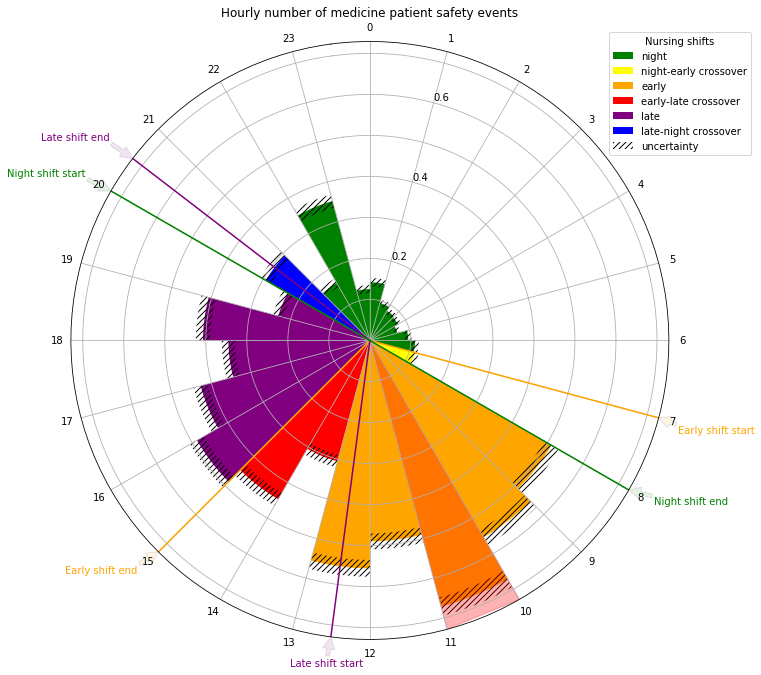

In [14]:
night_radii = np.zeros(len(radii))
night_early_radii = np.zeros(len(radii))
early_radii = np.zeros(len(radii))
early_late_radii = np.zeros(len(radii))
late_radii = np.zeros(len(radii))
late_night_radii = np.zeros(len(radii))
for i in range(24):
    if i==7: night_early_radii[i] = radii[i]
    elif i >= 8 and i <= 12: early_radii[i] = radii[i]
    elif i==13 or i==14: early_late_radii[i] = radii[i]
    elif i >= 15 and i <= 19: late_radii[i] = radii[i]
    elif i==20: late_night_radii[i] = radii[i]
    else: night_radii[i] = radii[i]
plt.figure(figsize=(11,11))
ax = plt.subplot(111, projection='polar');
ax.bar(theta, night_radii, width=width,label='night',color='green');
ax.bar(theta, night_early_radii, width=width, label='night-early crossover', color='yellow')
ax.bar(theta, early_radii, width=width,label='early',color='orange');
ax.bar(theta, early_late_radii, width=width, label='early-late crossover', color='red')
ax.bar(theta, late_radii, width=width,label='late',color='purple');
ax.bar(theta, late_night_radii, width=width, label='late-night crossover', color='blue')
ax.bar(theta, 2*radii_err, bottom=radii-radii_err,width=width,alpha=0.5,color='none',hatch="////",label='uncertainty');
ax.set_theta_offset(np.pi/2 + width/2)
ax.set_theta_direction(-1)
yticklabels = ax.get_yticks()
yticklabels = [round(item,1) for item in yticklabels]
for i,item in enumerate(yticklabels):
    if i%2==0: yticklabels[i]=''
ax.set_yticklabels(yticklabels)
#plt.xlabel('hour occured')
plt.title('Hourly number of medicine patient safety events',y=1)
plt.legend(loc=(0.9,0.81),title='Nursing shifts')
lines, labels = plt.thetagrids( theta_deg, (data_x) );
ax.axvspan(theta[np.argmax(radii)]-width/2,theta[np.argmax(radii)]+width/2,color='red',alpha=0.3);
ax.axvline(theta[7]-width/2,color='orange');
ax.axvline(theta[15]-width/2,color='orange');
ax.axvline(theta[12],color='purple');
ax.axvline(theta[20],color='purple');
ax.axvline(theta[20]-width/2,color='green');
ax.axvline(theta[8]-width/2,color='green');
ymax = ax.get_ylim()[1]
ax.annotate('Early shift start',xy=(theta[7]-width/2,ax.get_ylim()[1]),xytext=(theta[7]-width/2,ymax*1.2),color='orange',ha='center',
           arrowprops=dict(facecolor='orange',alpha=0.1));
ax.annotate('Early shift end',xy=(theta[15]-width/2,ax.get_ylim()[1]),xytext=(theta[15]-width/2,ymax*1.1),color='orange',ha='right',
           arrowprops=dict(facecolor='orange',alpha=0.1));
ax.annotate('Late shift start',xy=(theta[12],ax.get_ylim()[1]),xytext=(theta[12],round_up(ymax,1)),color='purple',ha='center',
           arrowprops=dict(facecolor='purple',alpha=0.1));
ax.annotate('Late shift end',xy=(theta[20],ax.get_ylim()[1]),xytext=(theta[20],round_up(ymax,1)),color='purple',ha='right',
           arrowprops=dict(facecolor='purple',alpha=0.1));
ax.annotate('Night shift start',xy=(theta[20]-width/2,ax.get_ylim()[1]),xytext=(theta[20]-width/2,round_up(ymax,1)),color='green',ha='right',
           arrowprops=dict(facecolor='green',alpha=0.1));
ax.annotate('Night shift end',xy=(theta[8]-width/2,ax.get_ylim()[1]),xytext=(theta[8]-width/2,round_up(ymax,1)),color='green',ha='left',
           arrowprops=dict(facecolor='green',alpha=0.1));
plt.savefig('hour.png')
plt.savefig('hour.pdf')

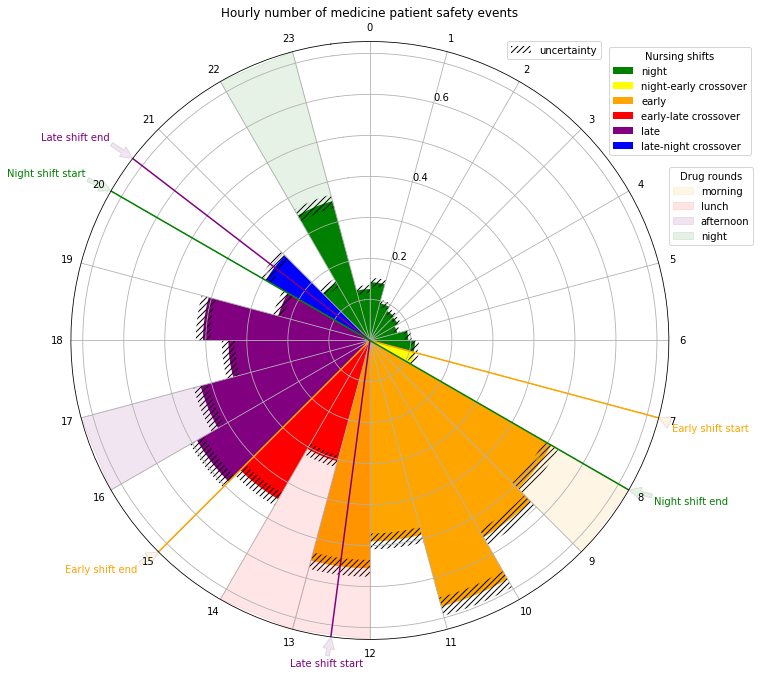

In [15]:
night_radii = np.zeros(len(radii))
night_early_radii = np.zeros(len(radii))
early_radii = np.zeros(len(radii))
early_late_radii = np.zeros(len(radii))
late_radii = np.zeros(len(radii))
late_night_radii = np.zeros(len(radii))
for i in range(24):
    if i==7: night_early_radii[i] = radii[i]
    elif i >= 8 and i <= 12: early_radii[i] = radii[i]
    elif i==13 or i==14: early_late_radii[i] = radii[i]
    elif i >= 15 and i <= 19: late_radii[i] = radii[i]
    elif i==20: late_night_radii[i] = radii[i]
    else: night_radii[i] = radii[i]
plt.figure(figsize=(11,11))
ax = plt.subplot(111, projection='polar');
ax.bar(theta, night_radii, width=width,label='night',color='green');
ax.bar(theta, night_early_radii, width=width, label='night-early crossover', color='yellow')
ax.bar(theta, early_radii, width=width,label='early',color='orange');
ax.bar(theta, early_late_radii, width=width, label='early-late crossover', color='red')
ax.bar(theta, late_radii, width=width,label='late',color='purple');
ax.bar(theta, late_night_radii, width=width, label='late-night crossover', color='blue')
uncertainty = ax.bar(theta, 2*radii_err, bottom=radii-radii_err,width=width,alpha=0.5,color='none',hatch="////");
ax.set_theta_offset(np.pi/2 + width/2)
ax.set_theta_direction(-1)
ax.set_yticklabels(['',0.2,'',0.4,'',0.6])
#plt.xlabel('hour occured')
plt.title('Hourly number of medicine patient safety events',y=1)
shift_legend = plt.legend(loc=(0.9,0.81),title='Nursing shifts')
lines, labels = plt.thetagrids( theta_deg, (data_x) );
for morning_hour in range(8,9):
    morning_round = ax.axvspan(theta[morning_hour]-width/2,theta[morning_hour]+width/2,color='orange',alpha=0.1);
for lunch_hour in range(12,14):
    lunch_round = ax.axvspan(theta[lunch_hour]-width/2,theta[lunch_hour]+width/2,color='red',alpha=0.1);
for afternoon_hour in range(16,17):
    afternoon_round = ax.axvspan(theta[afternoon_hour]-width/2,theta[afternoon_hour]+width/2,color='purple',alpha=0.1);
for night_hour in range(22,23):
    night_round = ax.axvspan(theta[night_hour]-width/2,theta[night_hour]+width/2,color='green',alpha=0.1);
round_legend = plt.legend([morning_round,lunch_round,afternoon_round,night_round],['morning','lunch','afternoon','night'],
                         title='Drug rounds',loc=(1.0,0.66))
uncertainty_legend = plt.legend([uncertainty],['uncertainty'],loc=(0.73,0.97))
ax.add_artist(shift_legend)
ax.add_artist(round_legend)
ax.axvline(theta[7]-width/2,color='orange');
ax.axvline(theta[15]-width/2,color='orange');
ax.axvline(theta[12],color='purple');
ax.axvline(theta[20],color='purple');
ax.axvline(theta[20]-width/2,color='green');
ax.axvline(theta[8]-width/2,color='green');
ax.annotate('Early shift start',xy=(theta[7]-width/2,ax.get_ylim()[1]),xytext=(theta[7]-width/2,0.86),color='orange',ha='center',
           arrowprops=dict(facecolor='orange',alpha=0.1));
ax.annotate('Early shift end',xy=(theta[15]-width/2,ax.get_ylim()[1]),xytext=(theta[15]-width/2,0.8),color='orange',ha='right',
           arrowprops=dict(facecolor='orange',alpha=0.1));
ax.annotate('Late shift start',xy=(theta[12],ax.get_ylim()[1]),xytext=(theta[12],0.8),color='purple',ha='center',
           arrowprops=dict(facecolor='purple',alpha=0.1));
ax.annotate('Late shift end',xy=(theta[20],ax.get_ylim()[1]),xytext=(theta[20],0.8),color='purple',ha='right',
           arrowprops=dict(facecolor='purple',alpha=0.1));
ax.annotate('Night shift start',xy=(theta[20]-width/2,ax.get_ylim()[1]),xytext=(theta[20]-width/2,0.8),color='green',ha='right',
           arrowprops=dict(facecolor='green',alpha=0.1));
ax.annotate('Night shift end',xy=(theta[8]-width/2,ax.get_ylim()[1]),xytext=(theta[8]-width/2,0.8),color='green',ha='left',
           arrowprops=dict(facecolor='green',alpha=0.1));

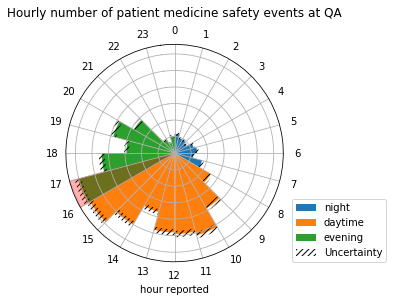

In [16]:
df_rep = df.copy()
df_rep = df_rep[df_rep.inc_dreported > '2016-03-31']
df_rep = df_rep[df_rep.inc_dreported < '2019-10-01']
df_rep['rep_hour'] = df_rep['inc_submittedtime'].str[:2]
df_rep = df_rep.astype({'rep_hour':'int'})
data_y_tot,_ = np.histogram(df_rep.rep_hour.values, bins=bins)
data_y = data_y_tot/total_days
data_y_err = np.sqrt(data_y_tot)/total_days
radii = data_y
radii_err = data_y_err
morning_radii = np.zeros(len(radii))
afternoon_radii = np.zeros(len(radii))
evening_radii = np.zeros(len(radii))
for i in range(24):
    if i <= 7: morning_radii[i] = radii[i]
    elif i >= 8 and i <= 15: afternoon_radii[i] = radii[i]
    else: evening_radii[i] = radii[i]
ax = plt.subplot(111, projection='polar');
ax.bar(theta, morning_radii, width=width,label='night');
ax.bar(theta, afternoon_radii, width=width,label='daytime');
ax.bar(theta, evening_radii, width=width,label='evening');
ax.bar(theta, 2*radii_err, bottom=radii-radii_err,width=width,alpha=0.5,color='none',hatch="////",label='Uncertainty');
ax.set_theta_offset(np.pi/2 + width/2)
ax.set_theta_direction(-1)
ax.set_yticklabels([])
plt.xlabel('hour reported')
plt.title('Hourly number of patient medicine safety events at QA',y=1.1)
plt.legend(loc=(1.04,0))
lines, labels = plt.thetagrids( theta_deg, (data_x) );
ax.axvspan(theta[np.argmax(radii)]-width/2,theta[np.argmax(radii)]+width/2,color='red',alpha=0.3);

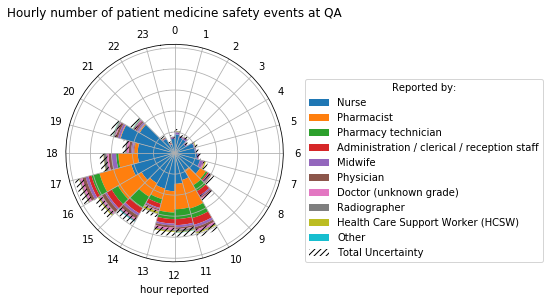

In [17]:
reportedby_counts = df['inc_reportedby'].value_counts().drop(labels=[''])
reportedby_counts_nlargest = reportedby_counts.nlargest(9)
thresh = reportedby_counts_nlargest[-1]
reportedby_counts = reportedby_counts.append(pd.Series(reportedby_counts[reportedby_counts.values < thresh].sum(),index=['Other']))
reportedby_counts = reportedby_counts[reportedby_counts.values >= thresh]

ax = plt.subplot(111, projection='polar')
cumulative_bottom = 0
for i,counts in reportedby_counts.items():
    radii_reported_tot,_ = np.histogram(df_rep[df_rep['inc_reportedby']==i].rep_hour.values, bins=bins)
    radii_reported = radii_reported_tot/total_days
    ax.bar(theta, radii_reported, bottom=cumulative_bottom, width=width, label=i);
    cumulative_bottom += radii_reported

ax.bar(theta, radii_err, bottom=cumulative_bottom-radii_err/2,width=width,alpha=0.5,color='none',hatch="////",label='Total Uncertainty');
ax.set_theta_offset(np.pi/2 + width/2)
ax.set_theta_direction(-1)
ax.set_yticklabels([])
plt.xlabel('hour reported')
plt.title('Hourly number of patient medicine safety events at QA',y=1.1)
plt.legend(loc=(1.1,0),title='Reported by:')
lines, labels = plt.thetagrids( theta_deg, (data_x) )

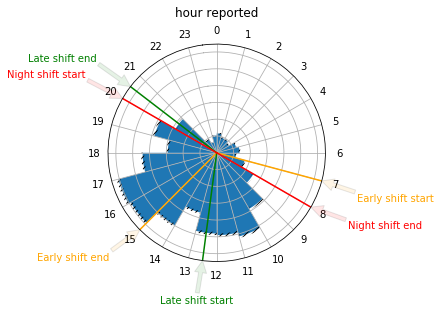

In [18]:
ax = plt.subplot(111, projection='polar')
ax.bar(theta, radii, width=width,label='Data');
ax.bar(theta, radii_err, bottom=radii-radii_err/2,width=width,alpha=0.5,color='none',hatch="////",label='Uncertainty');
ax.set_theta_offset(np.pi/2 + width/2)
ax.set_theta_direction(-1)
ax.set_yticklabels([])
#plt.xlabel('hour in day')
plt.title('hour reported',y=1.1)
#plt.legend(loc=(1.04,0))
lines, labels = plt.thetagrids( theta_deg, (data_x) )
ax.axvline(theta[7]-width/2,color='orange');
ax.axvline(theta[15]-width/2,color='orange');
ax.axvline(theta[12],color='green');
ax.axvline(theta[20],color='green');
ax.axvline(theta[20]-width/2,color='red');
ax.axvline(theta[8]-width/2,color='red');
ax.annotate('Early shift start',xy=(theta[7]-width/2,ax.get_ylim()[1]),xytext=(theta[7]-width/2,1.1),color='orange',ha='center',
           arrowprops=dict(facecolor='orange',alpha=0.1));
ax.annotate('Early shift end',xy=(theta[15]-width/2,ax.get_ylim()[1]),xytext=(theta[15]-width/2,0.9),color='orange',ha='right',
           arrowprops=dict(facecolor='orange',alpha=0.1));
ax.annotate('Late shift start',xy=(theta[12],ax.get_ylim()[1]),xytext=(theta[12],0.9),color='green',ha='center',
           arrowprops=dict(facecolor='green',alpha=0.1));
ax.annotate('Late shift end',xy=(theta[20],ax.get_ylim()[1]),xytext=(theta[20],0.9),color='green',ha='right',
           arrowprops=dict(facecolor='green',alpha=0.1));
ax.annotate('Night shift start',xy=(theta[20]-width/2,ax.get_ylim()[1]),xytext=(theta[20]-width/2,0.9),color='red',ha='right',
           arrowprops=dict(facecolor='red',alpha=0.1));
ax.annotate('Night shift end',xy=(theta[8]-width/2,ax.get_ylim()[1]),xytext=(theta[8]-width/2,0.9),color='red',ha='left',
           arrowprops=dict(facecolor='red',alpha=0.1));